In [192]:
###############################
### Method 02

## STEP - read the data
import pandas as pd
cols_ = ['changeType', 'timestamp']
# df = pd.read_csv("sample_data_01b.csv", parse_dates=["timestamp"], sep='\t',usecols=cols_)
df = pd.read_csv("sample_data_01c.csv", parse_dates=["timestamp"], sep='\t',usecols=cols_)


In [193]:
df.head(5)

,changeType,timestamp
0,Delete,2023-04-02 02:00:01
1,Modify,2023-01-01 15:27:14
2,Modify,2023-03-02 01:32:24
3,Delete,2022-08-30 23:45:10
4,Modify,2023-04-06 02:56:53


In [194]:
## STEP- preprocess the data

import pandas as pd
import numpy as np

# Step 1: Preprocess the data
# df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')  # flooring the timestamp to hour
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day

# df['month'] = df['timestamp'].dt.month # NOTE: this is not necessary if full year's data is not available.
# df['year'] = df['timestamp'].dt.year # NOTE: this is not necessary if multiple year's data is not available.
df['day_of_week'] = df['timestamp'].dt.dayofweek # NOTE: this could be made as binary (WeekDay vs WeekEnd)?

# Step 2: Encode categorical variables
# NOTE: encode other categorial variables if necessary
for col in ['changeType']:
    # df[f"{col}_encoded"] = pd.Categorical(df[col]).codes
    ## staring encoding from 1 rather than 0
    df[f"{col}_encoded"] = pd.Categorical(df[col]).codes + 1


In [195]:
df

,changeType,timestamp,hour,day,day_of_week,changeType_encoded
0,Delete,2023-04-02 02:00:00,2,2,6,2
1,Modify,2023-01-01 15:00:00,15,1,6,3
2,Modify,2023-03-02 01:00:00,1,2,3,3
3,Delete,2022-08-30 23:00:00,23,30,1,2
4,Modify,2023-04-06 02:00:00,2,6,3,3
...,...,...,...,...,...,...
99995,Modify,2023-02-20 23:00:00,23,20,0,3
99996,Delete,2022-09-16 04:00:00,4,16,4,2
99997,Delete,2022-09-21 04:00:00,4,21,2,2
99998,Write,2022-09-10 06:00:00,6,10,5,4


In [196]:

## Aggregate the data by unique row and then count
df_with_count = df.groupby(df.columns.tolist(), as_index=False).size().rename(columns={'size':'count'})
df_with_count

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count
0,Create,2022-08-01 01:00:00,1,1,0,1,4
1,Create,2022-08-01 02:00:00,2,1,0,1,3
2,Create,2022-08-01 03:00:00,3,1,0,1,5
3,Create,2022-08-01 04:00:00,4,1,0,1,6
4,Create,2022-08-01 05:00:00,5,1,0,1,5
...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,2,4,2
21211,Write,2023-04-12 20:00:00,20,12,2,4,3
21212,Write,2023-04-12 21:00:00,21,12,2,4,8
21213,Write,2023-04-12 22:00:00,22,12,2,4,1


In [157]:
## STEP (contextual)- include hours that did not see any change - the count is 0 (zero)
# this is more useful is we want to account for higher than normal 0 observation/count.

# Create a DataFrame with all possible hours between the minimum and maximum timestamps
all_hours = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='H')
all_hours_df = pd.DataFrame({'timestamp': all_hours})

# Merge the aggregated DataFrame with the all_hours_df DataFrame
df_with_all_hours_count = all_hours_df.merge(df_with_count, on='timestamp', how='left')
# df_with_all_hours_count
# df_with_all_hours_count[df_with_all_hours_count['count'].isna()]

## STEP - fill in no-change as 'NoChange' and null count values with 0
df_with_all_hours_count['changeType'].fillna('NoChange', inplace=True)
df_with_all_hours_count['count'].fillna(0, inplace=True)
df_with_all_hours_count['changeType_encoded'].fillna(0, inplace=True)

## fill in other data based on timestamp
df_with_all_hours_count['hour'].fillna(df_with_all_hours_count['timestamp'].dt.hour, inplace=True)
df_with_all_hours_count['day'].fillna(df_with_all_hours_count['timestamp'].dt.day, inplace=True)
# df_with_all_hours_count['month'].fillna(df_with_all_hours_count['timestamp'].dt.month, inplace=True)
df_with_all_hours_count['day_of_week'].fillna(df_with_all_hours_count['timestamp'].dt.dayofweek, inplace=True)

# df_with_all_hours_count
# df_with_all_hours_count[df_with_all_hours_count['count'].isnull()]

## update/reset the count dataframe
# df_with_count = df_with_all_hours_count 


## NOTE: add other variables/columns like moving average, distance from the local mean?, in future

,timestamp,changeType,hour,day,day_of_week,changeType_encoded,count


In [172]:

#### TODO (if needed): Do additional Feature Engineering if needed
# # Step 7: Feature engineering - Interaction terms and polynomials
# df_reduced['hour_square'] = df_reduced['hour'] ** 2
# df_reduced['day_square'] = df_reduced['day'] ** 2
# df_reduced['month_square'] = df_reduced['month'] ** 2

# df_reduced['hour_day_interaction'] = df_reduced['hour'] * df_reduced['day']
# df_reduced['hour_month_interaction'] = df_reduced['hour'] * df_reduced['month']
# df_reduced['day_month_interaction'] = df_reduced['day'] * df_reduced['month']


,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count
0,Create,2022-08-01 01:00:00,1,1,0,1,4
1,Create,2022-08-01 02:00:00,2,1,0,1,3
2,Create,2022-08-01 03:00:00,3,1,0,1,5
3,Create,2022-08-01 04:00:00,4,1,0,1,6
4,Create,2022-08-01 05:00:00,5,1,0,1,5
...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,2,4,2
21211,Write,2023-04-12 20:00:00,20,12,2,4,3
21212,Write,2023-04-12 21:00:00,21,12,2,4,8
21213,Write,2023-04-12 22:00:00,22,12,2,4,1


In [197]:
## Add more feature columns- Feature Engineering using Fourier transform. 

import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

## Add Fourier terms feature for seasonality
# We are setting the number of Fourier terms at 2, to be added as features. 
# In this case, we are adding two pairs of sine and cosine terms (sin_1, cos_1, sin_2, and cos_2).
# The choice of num_fourier_terms as 2 is somewhat arbitrary and serves as a starting point. 
# In practice, you may want to experiment with different numbers of Fourier terms (e.g., 3, 4, or more) to see which provides the best model performance for your specific data.
# We are assuming daily seasonality; you can adjust it as needed
num_fourier_terms = 2
daily_period = 24
## Some readings for understanding the use of seasonality
  # https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3
  # https://towardsdatascience.com/how-to-add-fourier-terms-to-your-regression-seasonality-analysis-using-python-scipy-99a94d3ae51
  # https://medium.com/swlh/seasonality-analysis-and-forecast-in-time-series-b8fbba820327
  # https://otexts.com/fpp2/complexseasonality.html
  # https://pkg.robjhyndman.com/forecast/reference/fourier.html

for n in range(1, num_fourier_terms + 1):
    df_with_count[f"sin_{n}"] = np.sin(2 * np.pi * n * df_with_count["hour"] / daily_period)
    df_with_count[f"cos_{n}"] = np.cos(2 * np.pi * n * df_with_count["hour"] / daily_period)

# NOTE: Question - how does this fourier transform even help? 
  # the values of the transform for same hours across different days is the same.
  # the value of the hour already captures this, so, how does it help?
  # may be we need to alter how to do the transform; by including counts too may be??

## NOTE: to include weekly Fourier terms use this
# num_fourier_terms_weekly = 2
# weekly_period = 24 * 7  # 24 hours * 7 days

# for n in range(1, num_fourier_terms_weekly + 1):
#     df_with_count[f"sin_weekly_{n}"] = np.sin(2 * np.pi * n * df_with_count["hour"] / weekly_period)
#     df_with_count[f"cos_weekly_{n}"] = np.cos(2 * np.pi * n * df_with_count["hour"] / weekly_period)



In [92]:
df_with_count

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,sin_1,cos_1,sin_2,cos_2
0,Create,2022-08-01 01:00:00,1,1,0,1,4,0.258819,0.965926,0.500000,8.660254e-01
1,Create,2022-08-01 02:00:00,2,1,0,1,3,0.500000,0.866025,0.866025,5.000000e-01
2,Create,2022-08-01 03:00:00,3,1,0,1,5,0.707107,0.707107,1.000000,6.123234e-17
3,Create,2022-08-01 04:00:00,4,1,0,1,6,0.866025,0.500000,0.866025,-5.000000e-01
4,Create,2022-08-01 05:00:00,5,1,0,1,5,0.965926,0.258819,0.500000,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,2,4,2,-0.965926,0.258819,-0.500000,-8.660254e-01
21211,Write,2023-04-12 20:00:00,20,12,2,4,3,-0.866025,0.500000,-0.866025,-5.000000e-01
21212,Write,2023-04-12 21:00:00,21,12,2,4,8,-0.707107,0.707107,-1.000000,-4.286264e-16
21213,Write,2023-04-12 22:00:00,22,12,2,4,1,-0.500000,0.866025,-0.866025,5.000000e-01


In [198]:
# STEP- Start model development

## setup expression for modeling
## NOTE: include additional features if needed for modeling
expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType + sin_1	+ cos_1	+ sin_2	+ cos_2"""
# expr = """count ~ hour + day_of_week + day + month + day_of_week:hour + changeType"""
# expr = """count ~ hour + day_of_week + day + day_of_week:hour + changeType"""
expr

'count ~ hour + day_of_week + day + day_of_week:hour + changeType + sin_1\t+ cos_1\t+ sin_2\t+ cos_2'

In [ ]:
## STEP (contextual)- training begins (on Split data) - NOTE: ignoring for now
# Training using TSCV (time series cross validation) by splitting the data 
# this is mainly done when performing hyperparameter tuning or feature selection, 
    # but here we can directly proceed to training/modeling on full data
# NOTE: we can use this method in the future

# Step 3 (Contextual): Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(df_with_count):
    df_train = df_with_count.iloc[train_index]
    df_test = df_with_count.iloc[test_index]
    
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

    # # Align the design matrices (i.e fill any missing columns with value 0 to make the columns between train and test equal)
    #NOTE: 
    ## Make sure the order of columns in the test set matches the order of columns in the training set
    ## currently not necessary in our analyses

    # missing_cols = set(X_train.columns) - set(X_test.columns)
    # for col in missing_cols:
    #     X_test[col] = 0
    # X_test = X_test[X_train.columns]
    

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    predicted_counts = predictions_summary_frame['mean']
    actual_counts = y_test['count']

    mse = ((predicted_counts - actual_counts) ** 2).mean()
    mse_scores.append(mse)

print("Mean Squared Error scores:", mse_scores)
print("Average Mean Squared Error:", np.mean(mse_scores))



In [199]:
df_with_count

,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,sin_1,cos_1,sin_2,cos_2
0,Create,2022-08-01 01:00:00,1,1,0,1,4,0.258819,0.965926,0.500000,8.660254e-01
1,Create,2022-08-01 02:00:00,2,1,0,1,3,0.500000,0.866025,0.866025,5.000000e-01
2,Create,2022-08-01 03:00:00,3,1,0,1,5,0.707107,0.707107,1.000000,6.123234e-17
3,Create,2022-08-01 04:00:00,4,1,0,1,6,0.866025,0.500000,0.866025,-5.000000e-01
4,Create,2022-08-01 05:00:00,5,1,0,1,5,0.965926,0.258819,0.500000,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,2,4,2,-0.965926,0.258819,-0.500000,-8.660254e-01
21211,Write,2023-04-12 20:00:00,20,12,2,4,3,-0.866025,0.500000,-0.866025,-5.000000e-01
21212,Write,2023-04-12 21:00:00,21,12,2,4,8,-0.707107,0.707107,-1.000000,-4.286264e-16
21213,Write,2023-04-12 22:00:00,22,12,2,4,1,-0.500000,0.866025,-0.866025,5.000000e-01


In [200]:
## STEP- Fit the model (on full data)

# Step 4: Fit the final model with the selected features
y, X = dmatrices(expr, df_with_count, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                21215
Model:                            GLM   Df Residuals:                    21203
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45476.
Date:                Thu, 27 Apr 2023   Deviance:                       20586.
Time:                        16:17:07   Pearson chi2:                 2.02e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0003516
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5457 

In [201]:
# Step 5: Fit the model 
predictions = poisson_model.get_prediction(X)
predictions_summary_frame = predictions.summary_frame()
# predicted_counts = predictions_summary_frame['mean']
# actual_counts = y['count']


In [202]:
# predicted_counts
# actual_counts
predictions_summary_frame


,mean,mean_se,mean_ci_lower,mean_ci_upper
0,4.727595,0.075929,4.581096,4.878780
1,4.715632,0.064352,4.591177,4.843461
2,4.699258,0.059798,4.583505,4.817934
3,4.681831,0.058639,4.568301,4.798184
4,4.666676,0.057585,4.555165,4.780917
...,...,...,...,...
21210,4.667657,0.046999,4.576444,4.760688
21211,4.681031,0.045639,4.592428,4.771343
21212,4.697824,0.043930,4.612508,4.784718
21213,4.714319,0.047510,4.622114,4.808362


In [203]:
## merge the predictions dataframe to counts dataframe
## NOTE: make sure that number of indexes are same and any row is not lost
# df_with_count.merge(predictions_summary_frame, how='inner')
df_with_count = df_with_count.join(predictions_summary_frame) # this will merge on the indexes
df_with_count


,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,sin_1,cos_1,sin_2,cos_2,mean,mean_se,mean_ci_lower,mean_ci_upper
0,Create,2022-08-01 01:00:00,1,1,0,1,4,0.258819,0.965926,0.500000,8.660254e-01,4.727595,0.075929,4.581096,4.878780
1,Create,2022-08-01 02:00:00,2,1,0,1,3,0.500000,0.866025,0.866025,5.000000e-01,4.715632,0.064352,4.591177,4.843461
2,Create,2022-08-01 03:00:00,3,1,0,1,5,0.707107,0.707107,1.000000,6.123234e-17,4.699258,0.059798,4.583505,4.817934
3,Create,2022-08-01 04:00:00,4,1,0,1,6,0.866025,0.500000,0.866025,-5.000000e-01,4.681831,0.058639,4.568301,4.798184
4,Create,2022-08-01 05:00:00,5,1,0,1,5,0.965926,0.258819,0.500000,-8.660254e-01,4.666676,0.057585,4.555165,4.780917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,2,4,2,-0.965926,0.258819,-0.500000,-8.660254e-01,4.667657,0.046999,4.576444,4.760688
21211,Write,2023-04-12 20:00:00,20,12,2,4,3,-0.866025,0.500000,-0.866025,-5.000000e-01,4.681031,0.045639,4.592428,4.771343
21212,Write,2023-04-12 21:00:00,21,12,2,4,8,-0.707107,0.707107,-1.000000,-4.286264e-16,4.697824,0.043930,4.612508,4.784718
21213,Write,2023-04-12 22:00:00,22,12,2,4,1,-0.500000,0.866025,-0.866025,5.000000e-01,4.714319,0.047510,4.622114,4.808362


In [204]:

from scipy.stats import poisson

#### Anomaly detection (is actually based on the threshold that we set)

# Set a threshold for anomalies (e.g., 2 times higher or lower then the expected count)
# Set upper and lower thresholds for anomalies
upper_threshold = 2
lower_threshold = 0.5

### With Regular Poisson #NOTE: reactivate this 
## Find anomalies that are twice more or twice less than the predicted counts
# actual_counts = actual_counts.reset_index(drop=True)
# predicted_counts = predicted_counts.reset_index(drop=True)

# Find anomalies that are twice more or twice less than the predicted counts
def find_anomalies(row):
    ratio_obs_vs_pred = row['count'] / row['mean']
    is_anomaly = (ratio_obs_vs_pred > upper_threshold) or (ratio_obs_vs_pred < lower_threshold)
    return pd.Series([ratio_obs_vs_pred, is_anomaly], index=['ratio', 'is_anomaly'])
    
anomalies = df_with_count.apply(find_anomalies, axis=1)


# Calculate the probability distribution for each predicted count
def get_pvalue(row):
    # ratio_obs_vs_pred = row['count'] / row['mean']
    pvalue_of_count = poisson.pmf(row['count'], row['mean'])
    return pd.Series([pvalue_of_count], index=['pvalue'])

pvalue = df_with_count.apply(get_pvalue, axis=1)

## NOTE: Continue

In [206]:
## merge the anomalies and p-value dataframe (NOTE: this could be made a single merge)
df_with_count = df_with_count.join(anomalies) # this will merge on the indexes
df_with_count = df_with_count.join(pvalue) # this will merge on the indexes
df_with_count


,changeType,timestamp,hour,day,day_of_week,changeType_encoded,count,sin_1,cos_1,sin_2,cos_2,mean,mean_se,mean_ci_lower,mean_ci_upper,ratio,is_anomaly,pvalue
0,Create,2022-08-01 01:00:00,1,1,0,1,4,0.258819,0.965926,0.500000,8.660254e-01,4.727595,0.075929,4.581096,4.878780,0.846096,False,0.184154
1,Create,2022-08-01 02:00:00,2,1,0,1,3,0.500000,0.866025,0.866025,5.000000e-01,4.715632,0.064352,4.591177,4.843461,0.636182,False,0.156493
2,Create,2022-08-01 03:00:00,3,1,0,1,5,0.707107,0.707107,1.000000,6.123234e-17,4.699258,0.059798,4.583505,4.817934,1.063998,False,0.173821
3,Create,2022-08-01 04:00:00,4,1,0,1,6,0.866025,0.500000,0.866025,-5.000000e-01,4.681831,0.058639,4.568301,4.798184,1.281550,False,0.135478
4,Create,2022-08-01 05:00:00,5,1,0,1,5,0.965926,0.258819,0.500000,-8.660254e-01,4.666676,0.057585,4.555165,4.780917,1.071426,False,0.173438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,Write,2023-04-12 19:00:00,19,12,2,4,2,-0.965926,0.258819,-0.500000,-8.660254e-01,4.667657,0.046999,4.576444,4.760688,0.428480,True,0.102336
21211,Write,2023-04-12 20:00:00,20,12,2,4,3,-0.866025,0.500000,-0.866025,-5.000000e-01,4.681031,0.045639,4.592428,4.771343,0.640884,False,0.158463
21212,Write,2023-04-12 21:00:00,21,12,2,4,8,-0.707107,0.707107,-1.000000,-4.286264e-16,4.697824,0.043930,4.612508,4.784718,1.702916,False,0.053631
21213,Write,2023-04-12 22:00:00,22,12,2,4,1,-0.500000,0.866025,-0.866025,5.000000e-01,4.714319,0.047510,4.622114,4.808362,0.212120,True,0.042268


In [207]:
anomalies.index

RangeIndex(start=0, stop=21215, step=1)

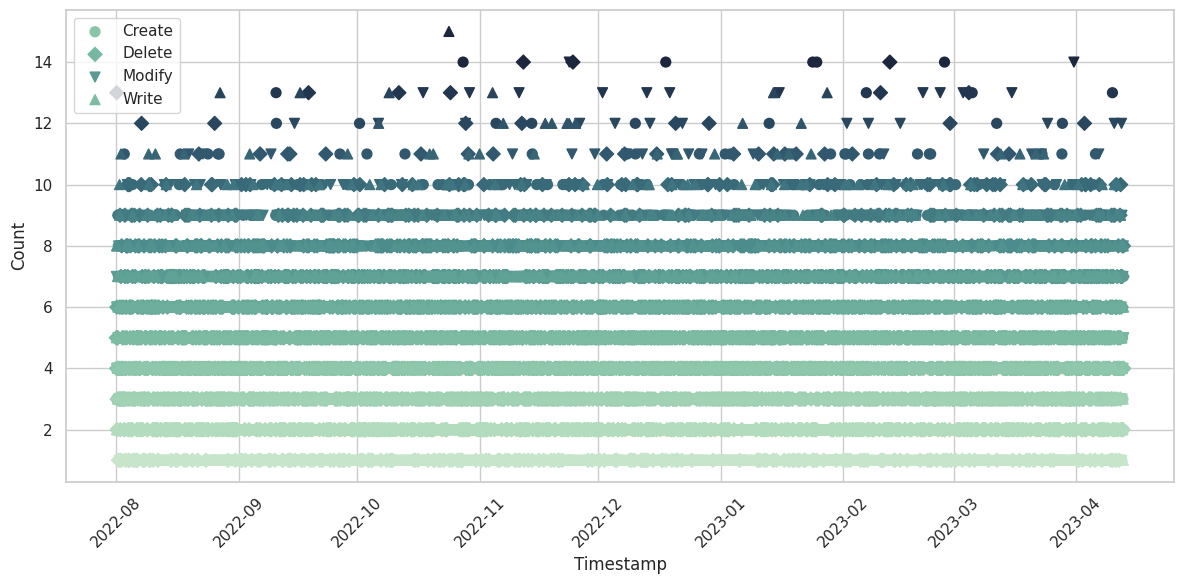

In [208]:
## Visualization (is better when nested index are defined properly)
## Reset index to include timestamp (as primary) and changeType (as secondary) index
## Making multilevel index
df_with_count.set_index(['timestamp', 'changeType'], inplace=True)
df_with_count

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set(style='whitegrid')

# Define marker and color dictionaries for different changeType values
marker_dict = {'Create': 'o', 'Update': 's', 'Delete': 'D', 'Modify': 'v', 'Write': '^'}
color_dict = {'Create': 'red', 'Update': 'blue', 'Delete': 'green', 'Modify': 'magenta', 'Write': 'yellow'}

# Get unique changeType values
# change_types = anomalies.index.get_level_values('changeType').unique()
change_types = df_with_count.index.get_level_values('changeType').unique()

# Create a wider plot
plt.figure(figsize=(12, 6))

# Iterate through unique changeTypes and plot a scatter plot for each
for change_type in change_types:
    # sub_df = anomalies.xs(change_type, level='changeType')
    sub_df = df_with_count.xs(change_type, level='changeType')

    # Apply jitter to points
    jitter = 0.2
    x_values = sub_df.index
    y_values = sub_df['count']
    x_values_posix = x_values.astype(np.int64) // 10**9
    x_jittered_posix = x_values_posix + np.random.uniform(-jitter, jitter, size=len(x_values))
    x_jittered = pd.to_datetime(x_jittered_posix, unit='s')

    # To get distinct color use
    # colors= color_dict[change_type]
    
    # Define gradient color based on 'count' values
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
    norm = plt.Normalize(y_values.min(), y_values.max())
    colors = cmap(norm(y_values))
    
    plt.scatter(
        x_jittered, y_values,
        c=colors, marker=marker_dict[change_type],
        s=50, # Adjust marker size
        label=change_type
    )

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()


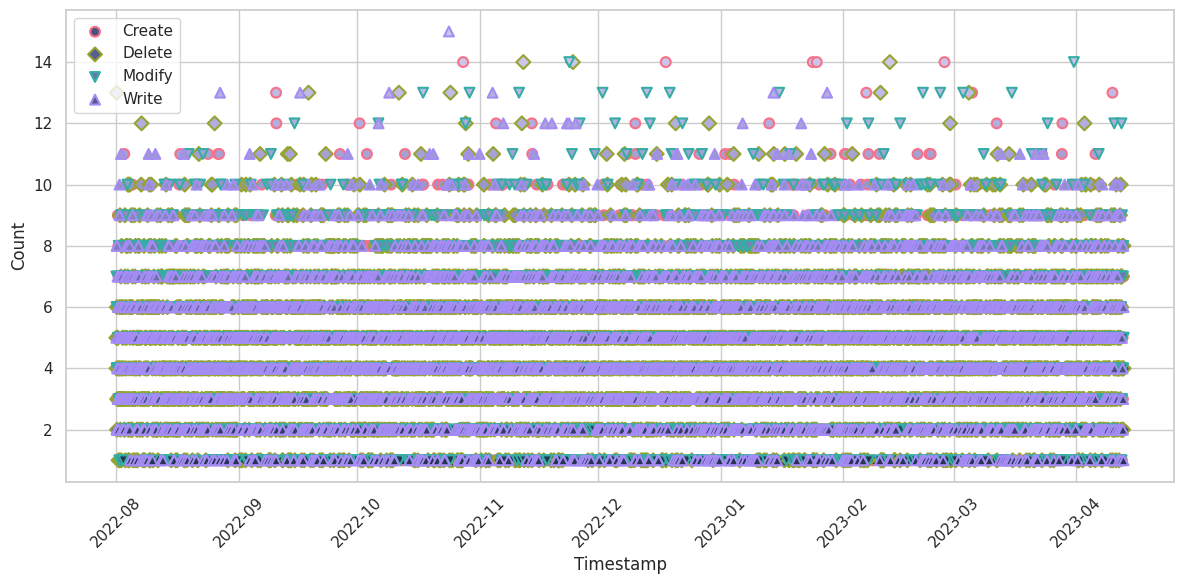

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df_with_count.set_index(['timestamp', 'changeType'], inplace=True)

# Set plot style
sns.set(style='whitegrid')

# Define marker dictionary for different changeType values
marker_dict = {'Create': 'o', 'Update': 's', 'Delete': 'D', 'Modify': 'v', 'Write': '^'}

# Get unique changeType values
change_types = df_with_count.index.get_level_values('changeType').unique()

# Get a color palette with the same number of colors as unique changeTypes
color_palette = sns.color_palette('husl', n_colors=len(change_types))
color_dict = dict(zip(change_types, color_palette))

# Create a wider plot
plt.figure(figsize=(12, 6))

# Iterate through unique changeTypes and plot a scatter plot for each
for change_type in change_types:
    sub_df = df_with_count.xs(change_type, level='changeType')

    # Apply jitter to points
    jitter = 0.2
    x_values = sub_df.index
    y_values = sub_df['count']
    x_values_posix = x_values.astype(np.int64) // 10**9
    x_jittered_posix = x_values_posix + np.random.uniform(-jitter, jitter, size=len(x_values))
    x_jittered = pd.to_datetime(x_jittered_posix, unit='s')
    
    # Define gradient color based on 'count' values
    # NOTE: Change this
    cmap = sns.cubehelix_palette(start=2.8, rot=.1, dark=0.2, light=0.8, reverse=True, as_cmap=True)
    ratio = sub_df['count'] / sub_df['mean']
    norm = plt.Normalize(ratio.min(), ratio.max())
    colors = cmap(norm(ratio))
    
    plt.scatter(
        x_jittered, y_values,
        c=colors, marker=marker_dict[change_type],
        s=50, # Adjust marker size
        label=change_type,
        edgecolors=color_dict[change_type], # Set edge color
        linewidth=1.5 # Adjust edge line width
    )

plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()


In [ ]:
# NOTE: Continue.....
# Keep the ZIP modeling and try others and delete the rest 

## Other TODO:
# find anamolies in the whole data rather than just the test-data. That's the point !
# save the possion model to keep learning, how?
# include ZIP
# include other features including seasonality
# include hyperparameter tuning

## other models
# try PyOD
# try PyCaret
# try XGBoost

## some source tutorials
  # https://towardsdatascience.com/time-series-anomaly-detection-techniques-in-python-193a4f4e4c4b
  # https://otexts.com/fpp2/
  # https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

In [ ]:
#### TODO: NOTE: additional modelling using ZIP
## ZIP modeling - still giving error

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from patsy import dmatrices

# Read the data
cols_ = ['changeType', 'timestamp']
df = pd.read_csv("sample_data_01c.csv", parse_dates=["timestamp"], sep='\t', usecols=cols_)

# Preprocess the data
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('H')

df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Encode categorical variables
df['changeType_encoded'] = pd.Categorical(df['changeType']).codes

# Aggregate the data
df_with_count = df.groupby(['timestamp', 'changeType_encoded']).size().reset_index(name='count')

# Create a DataFrame with all possible combinations of hours and change types
unique_hours = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='H')
unique_change_types = df['changeType_encoded'].unique()
all_combinations_df = pd.MultiIndex.from_product([unique_hours, unique_change_types], names=['timestamp', 'changeType_encoded']).to_frame(index=False)

# Merge the aggregated DataFrame with the all_combinations_df DataFrame
merged_df = all_combinations_df.merge(df_with_count, on=['timestamp', 'changeType_encoded'], how='left')

# Fill in missing values
merged_df['count'].fillna(0, inplace=True)

# Add additional time-based features
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['month'] = merged_df['timestamp'].dt.month
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek

# Add Fourier terms for seasonality
num_fourier_terms = 2
daily_period = 24

for n in range(1, num_fourier_terms + 1):
    merged_df[f"sin_{n}"] = np.sin(2 * np.pi * n * merged_df["hour"] / daily_period)
    merged_df[f"cos_{n}"] = np.cos(2 * np.pi * n * merged_df["hour"] / daily_period)

# Set the expression to include Fourier terms and changeType_encoded
expr = """count ~ hour + day_of_week + day + month + day_of_week:hour + changeType_encoded + """ + ' + '.join([f"sin_{n} + cos_{n}" for n in range(1, num_fourier_terms + 1)])

# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(merged_df):
    df_train = merged_df.iloc[train_index]
    df_test = merged_df.iloc[test_index]

    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()
    predicted_counts = predictions_summary_frame['mean']
    actual_counts = y_test['count']

    mse = ((predicted_counts - actual_counts) ** 2).mean()
    mse_scores.append(mse)

print("Mean Squared Error scores:", mse_scores)
print("Average Mean Squared Error:", np.mean(mse_scores))

"""
######## Regular (but variable lambda) Poisson
# Train the final model with the selected features
y, X = dmatrices(expr, merged_df, return_type='dataframe')
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Anomaly detection
predictions = poisson_model.get_prediction(X)
predictions_summary_frame = predictions.summary_frame()
predicted_counts = predictions_summary_frame['mean']
actual_counts = y['count']
############# Variable Poisson model boundry
"""

import statsmodels.discrete.count_model as cm

y, X = dmatrices(expr, merged_df, return_type='dataframe')
zip_model = cm.ZeroInflatedPoisson(y, X).fit()
print(zip_model.summary())

########### If doing ZIP modeling
# from statsmodels.discrete.count_model import ZeroInflatedPoisson

# # Train the final model with the selected features
# y, X = dmatrices(expr, merged_df, return_type='dataframe')

# # Define exog_infl for the zero-inflation process (using day_of_week and hour as an example)
# exog_infl = merged_df[['day_of_week', 'hour']]

# zip_model = ZeroInflatedPoisson(y, X, exog_infl=exog_infl).fit()
# print(zip_model.summary())

# # Anomaly detection
# predictions = zip_model.predict(X, exog_infl=exog_infl, which='mean')
# predicted_counts = predictions
############# ZIP model boundry

# Set upper and lower thresholds for anomalies
upper_threshold = 2
lower_threshold = 0.5

### With Regular Poisson #NOTE: reactivate this 
# Find anomalies that are twice more or twice less than the predicted counts
# anomalies = merged_df[((actual_counts > upper_threshold * predicted_counts) |
#                        (actual_counts < lower_threshold * predicted_counts))]

### With ZIP
# Reset the index for actual_counts
actual_counts = actual_counts.reset_index(drop=True)

# Calculate the anomaly_mask
# anomaly_mask = ((actual_counts.to_numpy() > upper_threshold * predicted_counts.to_numpy()) |
#                 (actual_counts.to_numpy() < lower_threshold * predicted_counts.to_numpy()))

anomaly_mask = ((actual_counts.to_numpy().reshape(-1) > upper_threshold * predicted_counts.to_numpy().reshape(-1)) |
                (actual_counts.to_numpy().reshape(-1) < lower_threshold * predicted_counts.to_numpy().reshape(-1)))


# Filter anomalies using the anomaly_mask
anomalies = merged_df[anomaly_mask]
#### ZIP method boundry


# Plot the anomalies
plt.scatter(anomalies.index, anomalies['count'], c='red', label='Anomalies')
# plt.plot(merged_df.index, merged_df['count'], label='Counts')
plt.scatter(merged_df.index, merged_df['count'], label='Counts', alpha=0.5)
plt.legend()
plt.show()

# Assign colors based on the anomaly_mask
colors = np.where(((actual_counts > upper_threshold * predicted_counts) |
                   (actual_counts < lower_threshold * predicted_counts)), 'red', 'blue')

# Plot the actual vs predicted counts
plt.scatter(predicted_counts, actual_counts, c=colors, alpha=0.5)
plt.xlabel('Predicted Counts')
plt.ylabel('Actual Counts')
plt.title('Actual vs Predicted Counts (Anomalies in red)')
plt.show()



In [133]:
predictions

0        2.445327
1        2.450243
2        2.455169
3        2.440421
4        2.606053
           ...   
24471    4.448889
24472    4.593768
24473    4.603003
24474    4.612257
24475    4.584552
Length: 24476, dtype: float64